In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the installed libraries and print their versions
import tensorflow as tf
import numpy as np
import cv2
import matplotlib
import pycocotools

# Print versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.15.0
NumPy version: 1.25.2
OpenCV version: 4.8.0
Matplotlib version: 3.7.1
Num GPUs Available:  0


In [ ]:
import pandas as pd
import sklearn

print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


Pandas version: 2.0.3
Scikit-learn version: 1.2.2


In [ ]:
extract_path = '/content/drive/MyDrive/dataset/VisDrone2019-DET-train'

if extract_path:
  print("Dataset extracted successfully.")

Dataset extracted successfully.


In [ ]:
import os
import cv2
import json

# Paths to the images and annotations
images_path = os.path.join(extract_path, 'images')
annotations_path = os.path.join(extract_path, 'annotations')

# Function to load an annotation file
def load_annotation(file_path):
    with open(file_path, 'r') as f:
        annotations = f.readlines()
    # Convert the annotations to a structured format if necessary
    return annotations

# Example of loading an image and its corresponding annotation
image_files = os.listdir(images_path)
annotation_files = os.listdir(annotations_path)

# Assuming filenames match between images and annotations
for img_file, ann_file in zip(image_files, annotation_files):
    img_path = os.path.join(images_path, img_file)
    ann_path = os.path.join(annotations_path, ann_file)

    # Load image
    image = cv2.imread(img_path)

    # Load annotation
    annotations = load_annotation(ann_path)

    # Print the image and annotation shapes (for verification)
    print(f"Image shape: {image.shape}")
    print(f"Annotations: {annotations}")

    # Break after one iteration for demonstration
    break


NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/dataset/VisDrone2019-DET-train/images'

In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/dataset/VisDrone2019-DET-val (3).zip'

# Path to extract the dataset
extract_path = '/content/drive/MyDrive/dataset/val '

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/dataset/VisDrone2019-DET-test-dev (1).zip'

# Path to extract the dataset
extract_path = '/content/drive/MyDrive/dataset/test'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")

Dataset extracted successfully.


In [ ]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import random

# Specify the paths to the images directory and the annotations directory
images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/images'
annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/annotations'

# Function to load images
def load_images(images_dir):
    images = {}
    for img_name in os.listdir(images_dir):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(images_dir, img_name)
            images[img_name] = Image.open(img_path)
    return images

# Function to load annotations for YOLO
def load_yolo_annotations(annotations_dir, images_dir):
    annotations = {}
    for ann_file in os.listdir(annotations_dir):
        if ann_file.endswith('.txt'):
            ann_path = os.path.join(annotations_dir, ann_file)
            img_name = os.path.splitext(ann_file)[0]
            img_path = os.path.join(images_dir, f"{img_name}.jpg")

            # Ensure the corresponding image exists
            if not os.path.exists(img_path):
                img_path = os.path.join(images_dir, f"{img_name}.png")
            if not os.path.exists(img_path):
                continue

            with Image.open(img_path) as img:
                img_width, img_height = img.size

            with open(ann_path, 'r') as f:
                lines = f.readlines()
            bboxes = []
            labels = []
            for line in lines:
                parts = line.strip().split(",")
                bbox_left = float(parts[0])
                bbox_top = float(parts[1])
                bbox_width = float(parts[2])
                bbox_height = float(parts[3])
                object_category = int(parts[5])

                # Convert to YOLO format: normalized coordinates
                x_center = (bbox_left + bbox_width / 2) / img_width
                y_center = (bbox_top + bbox_height / 2) / img_height
                width = bbox_width / img_width
                height = bbox_height / img_height

                bboxes.append([x_center, y_center, width, height])
                labels.append(object_category)

            annotations[img_name] = {'bboxes': bboxes, 'labels': labels}
    return annotations

# Load the images and annotations
images = load_images(images_dir)
annotations = load_yolo_annotations(annotations_dir, images_dir)

# Check the loaded data
print(f"Loaded {len(images)} images")
print(f"Loaded {len(annotations)} annotations")


Loaded 6471 images
Loaded 6471 annotations


In [ ]:
import os
import cv2

# Mapping VisDrone categories to YOLO class IDs
category_mapping = {
    1: 0,  # 'ignored regions' -> 0
    2: 1,  # 'pedestrian' -> 1
    3: 2,  # 'people' -> 2
    4: 3,  # 'bicycle' -> 3
    5: 4,  # 'car' -> 4
    6: 5,  # 'van' -> 5
    7: 6,  # 'truck' -> 6
    8: 7,  # 'tricycle' -> 7
    9: 8,  # 'awning-tricycle' -> 8
    10: 9, # 'bus' -> 9
    11: 10,# 'motor' -> 10
    12: 11 # 'others' -> 11
}

def convert_annotations(image_dir, annotation_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for annotation_file in os.listdir(annotation_dir):
        if annotation_file.endswith('.txt'):
            image_file = annotation_file.replace('.txt', '.jpg')
            image_path = os.path.join(image_dir, image_file)
            annotation_path = os.path.join(annotation_dir, annotation_file)

            # Read image to get dimensions
            image = cv2.imread(image_path)
            if image is None:
                continue
            image_height, image_width = image.shape[:2]

            # Read annotation file
            with open(annotation_path, 'r') as file:
                lines = file.readlines()

            yolo_lines = []
            for line in lines:
                parts = line.strip().split(',')
                bbox_left = float(parts[2])
                bbox_top = float(parts[3])
                bbox_width = float(parts[4])
                bbox_height = float(parts[5])
                object_category = int(parts[7])

                # Convert to YOLO format
                center_x = (bbox_left + bbox_width / 2) / image_width
                center_y = (bbox_top + bbox_height / 2) / image_height
                width = bbox_width / image_width
                height = bbox_height / image_height
                class_id = category_mapping.get(object_category, -1)

                if class_id != -1:
                    yolo_lines.append(f"{class_id} {center_x} {center_y} {width} {height}\n")

            # Write YOLO annotation file
            yolo_annotation_path = os.path.join(output_dir, annotation_file)
            with open(yolo_annotation_path, 'w') as file:
                file.writelines(yolo_lines)

# Convert annotations for training and validation sets
convert_annotations('/content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images',
                    '/content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/labels',
                    '/content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/output')

convert_annotations('/content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/images',
                    '/content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/labels',
                    '/content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/output')


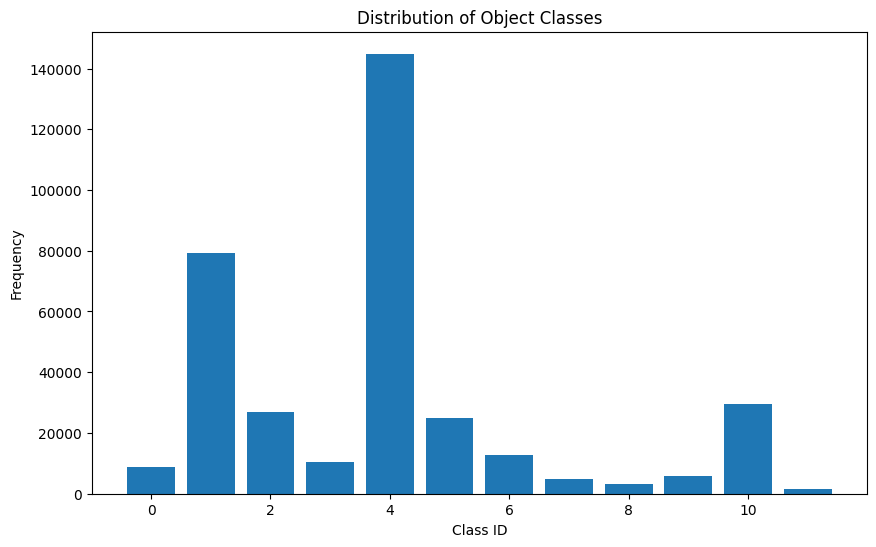

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Specify the path to the annotations directory
annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/annotations'

# Function to count the class distribution
def count_class_distribution(annotations_dir):
    class_counter = Counter()
    for file_name in os.listdir(annotations_dir):
        if file_name.endswith('.txt'):
            with open(os.path.join(annotations_dir, file_name), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split(',')
                    object_category = int(parts[5])  # Assuming object category is at index 5
                    class_counter[object_category] += 1
    return class_counter

# Get the class distribution
class_distribution = count_class_distribution(annotations_dir)

# Visualize the class distribution
def visualize_class_distribution(class_distribution):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Class ID')
    plt.ylabel('Frequency')
    plt.title('Distribution of Object Classes')
    plt.show()

visualize_class_distribution(class_distribution)


In [ ]:
## this is the distribution of various class as from the bar graph it is observed that class id 4 is more as compared to others.
0: pedestrian
  1: people
  2: bicycle
  3: car
  4: van
  5: truck
  6: tricycle
  7: awning-tricycle
  8: bus
  9: motor

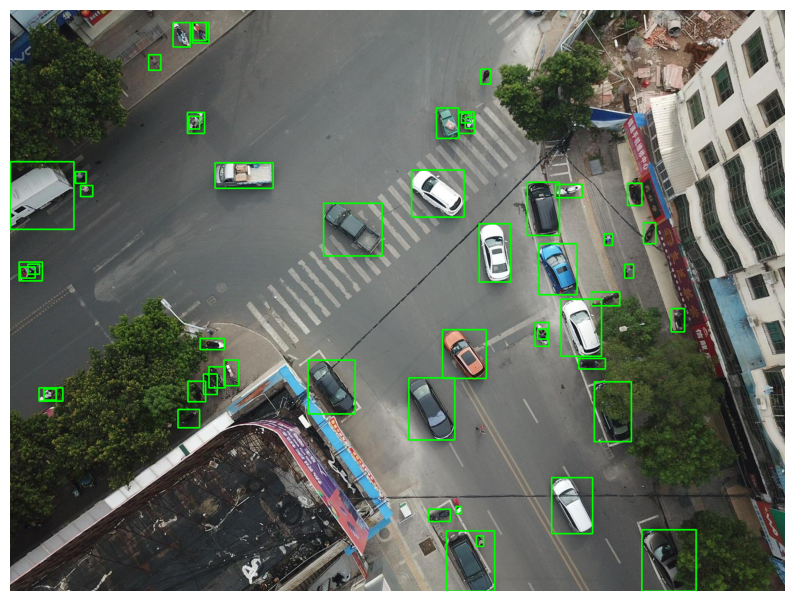

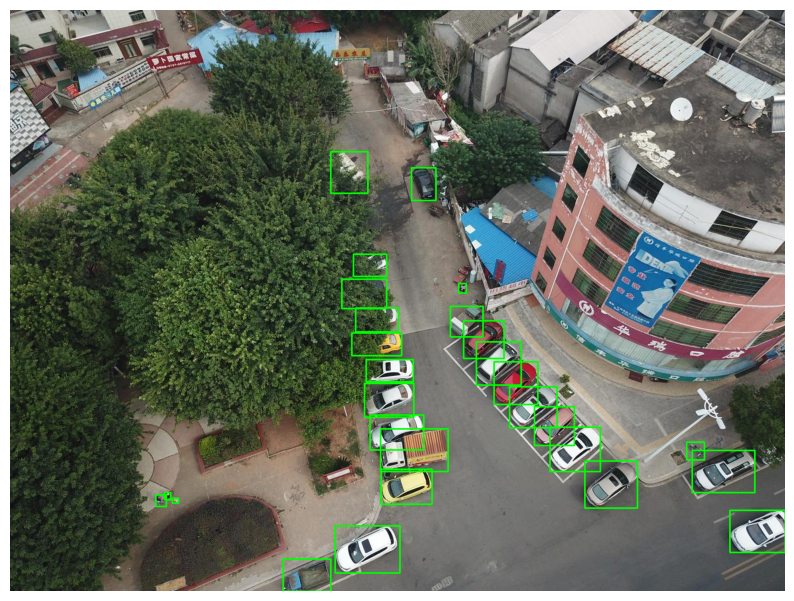

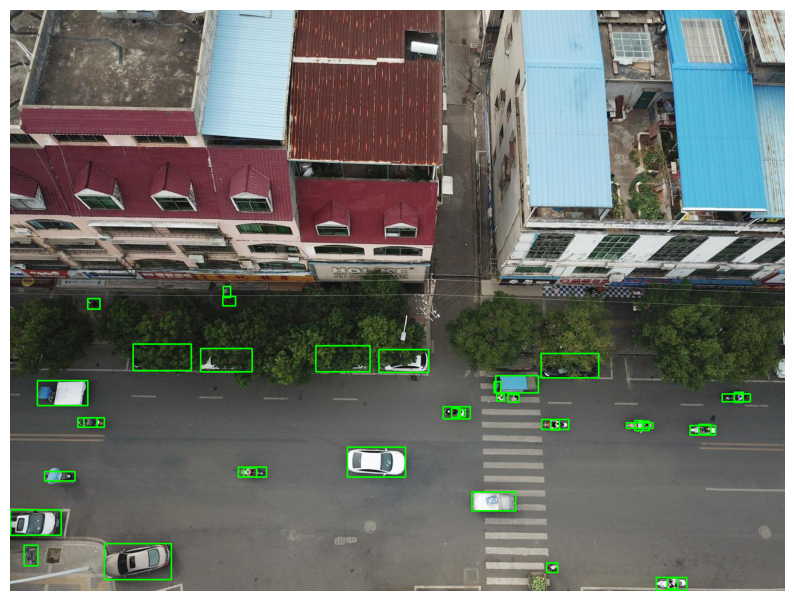

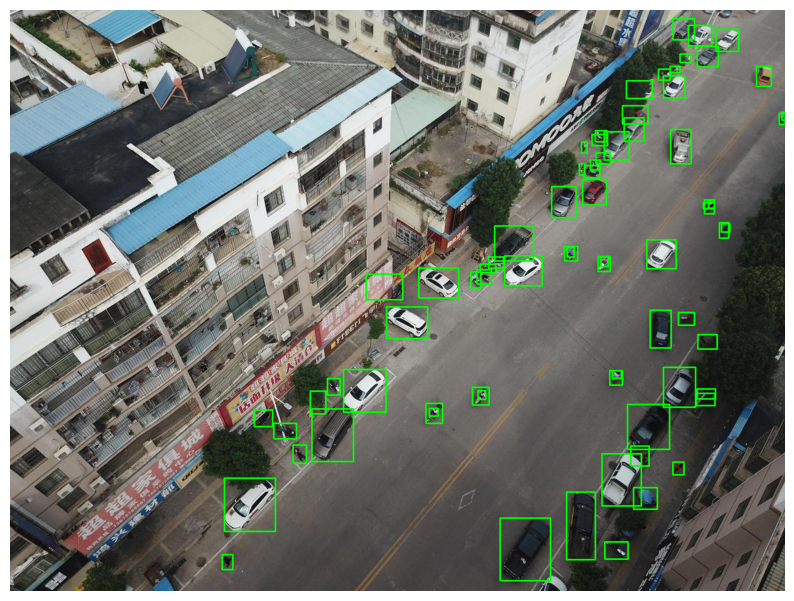

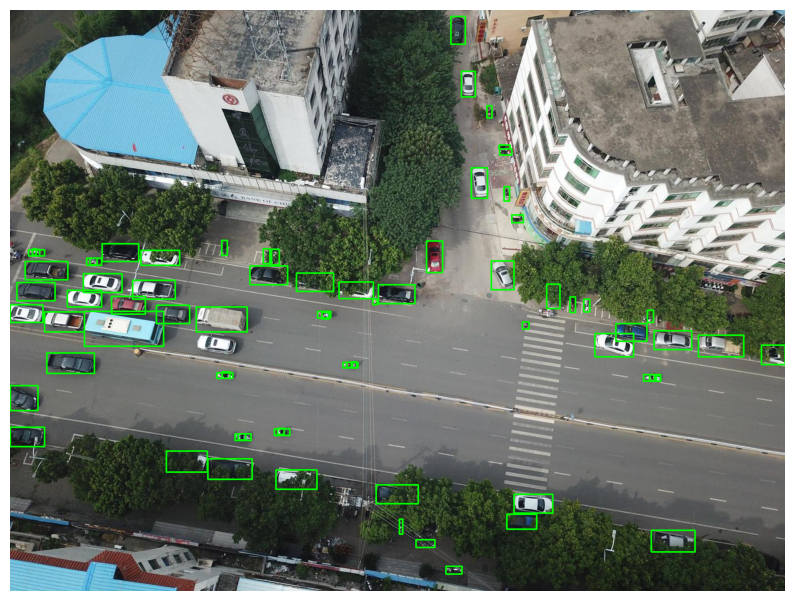

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Specify the path to the images directory
images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/images'

# Function to visualize sample images with bounding box annotations
def visualize_sample_images(images_dir, annotations_dir, num_samples=5):
    sample_files = os.listdir(annotations_dir)[:num_samples]
    for file_name in sample_files:
        img_name = os.path.splitext(file_name)[0] + '.jpg'
        img_path = os.path.join(images_dir, img_name)
        annotation_path = os.path.join(annotations_dir, file_name)

        image = cv2.imread(img_path)
        with open(annotation_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split(',')
                bbox_left, bbox_top, bbox_width, bbox_height = map(int, parts[:4])  # Assuming bbox coordinates are at index 0 to 3
                cv2.rectangle(image, (bbox_left, bbox_top), (bbox_left + bbox_width, bbox_top + bbox_height), (0, 255, 0), 2)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

visualize_sample_images(images_dir, annotations_dir)


In [ ]:
# Assuming we already have the class_distribution from Step 1

# Calculate class imbalance
total_samples = sum(class_distribution.values())
class_imbalance = {class_id: count / total_samples for class_id, count in class_distribution.items()}

# Print class imbalance
print("Class Imbalance:")
for class_id, imbalance in class_imbalance.items():
    print(f"Class {class_id}: {imbalance:.2f}")


Class Imbalance:
Class 1: 0.22
Class 2: 0.08
Class 10: 0.08
Class 4: 0.41
Class 5: 0.07
Class 8: 0.01
Class 6: 0.04
Class 3: 0.03
Class 9: 0.02
Class 7: 0.01
Class 0: 0.02
Class 11: 0.00


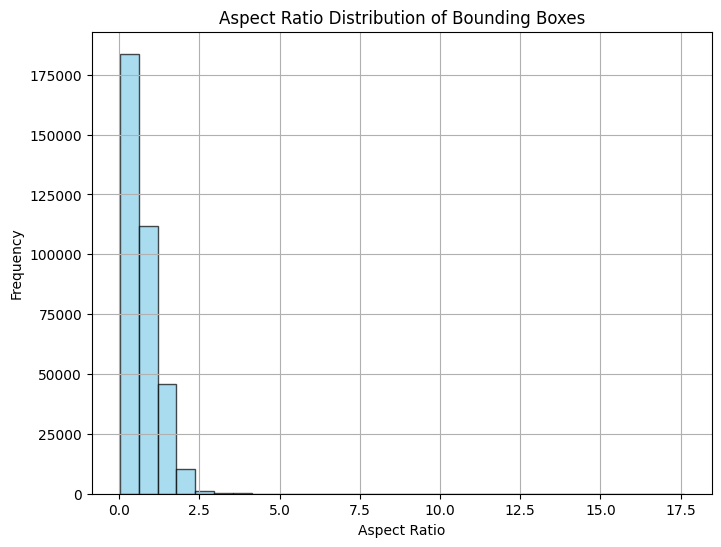

In [ ]:


# Function to calculate aspect ratios of bounding boxes
def calculate_aspect_ratios(annotations):
    aspect_ratios = []
    for ann in annotations.values():
        for bbox in ann['bboxes']:
            if bbox[3] != 0:  # Ensure non-zero height to avoid division by zero
                aspect_ratio = bbox[2] / bbox[3]
                aspect_ratios.append(aspect_ratio)
    return aspect_ratios

# Calculate aspect ratios
aspect_ratios = calculate_aspect_ratios(annotations)

# Visualize aspect ratio distribution using histogram
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Aspect Ratio Distribution of Bounding Boxes')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
## the above aspect ratio graph presents that people upright standing, vehicles, trucks, buildings, etc are there as aspect ratio shows the relationship between width and height of objects!

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



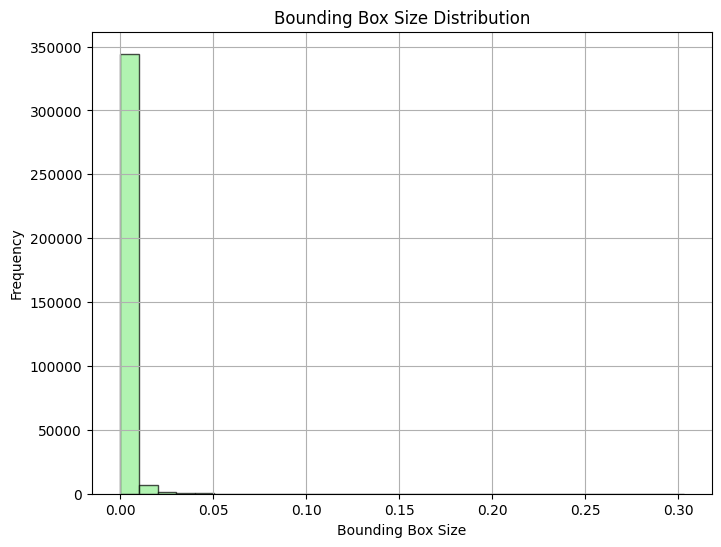

In [ ]:
def calculate_bbox_sizes(annotations):
    bbox_sizes = []
    for ann in annotations.values():
        for bbox in ann['bboxes']:
            bbox_width = bbox[2]
            bbox_height = bbox[3]
            bbox_area = bbox_width * bbox_height
            bbox_sizes.append(bbox_area)
    return bbox_sizes

# Calculate bounding box sizes
bbox_sizes = calculate_bbox_sizes(annotations)

# Visualize bounding box size distribution using histogram
plt.figure(figsize=(8, 6))
plt.hist(bbox_sizes, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Bounding Box Size Distribution')
plt.xlabel('Bounding Box Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

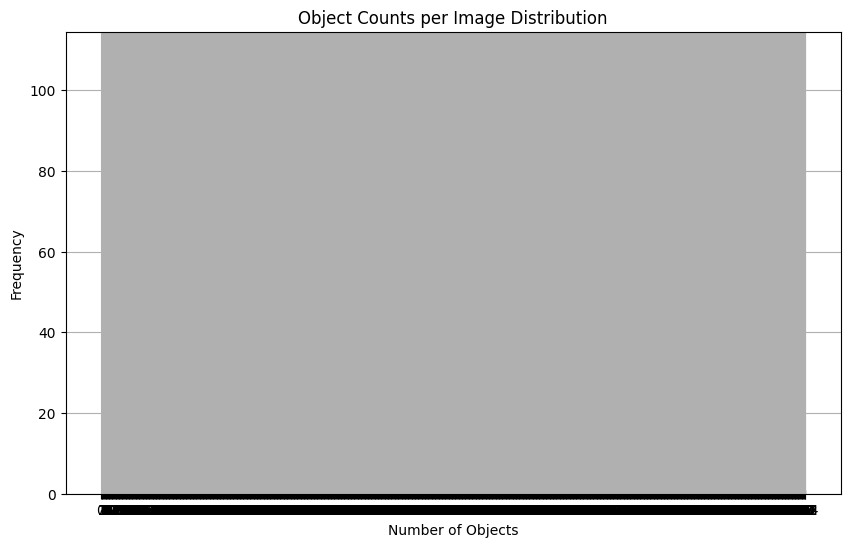

In [ ]:
object_counts = [len(annotation['bboxes']) for annotation in annotations.values()]

# Visualize object counts per image using histogram
plt.figure(figsize=(10, 6))
plt.hist(object_counts, bins=range(0, max(object_counts)+1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Object Counts per Image Distribution')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.xticks(range(0, max(object_counts)+1))
plt.grid(True)
plt.show()

In [ ]:
print(object_counts)

[52, 28, 38, 73, 73, 34, 68, 105, 46, 94, 55, 89, 52, 81, 52, 65, 55, 59, 125, 107, 169, 115, 87, 60, 85, 79, 89, 53, 33, 97, 116, 86, 44, 77, 46, 151, 52, 82, 28, 32, 12, 23, 77, 73, 27, 71, 122, 94, 37, 70, 110, 94, 71, 64, 87, 84, 107, 84, 62, 59, 72, 72, 24, 62, 102, 45, 30, 63, 104, 52, 22, 39, 24, 62, 83, 54, 35, 53, 77, 35, 64, 82, 66, 80, 100, 116, 56, 111, 86, 117, 108, 52, 81, 42, 52, 95, 72, 55, 15, 32, 64, 68, 18, 56, 64, 62, 44, 103, 121, 66, 86, 110, 83, 76, 93, 72, 108, 42, 15, 103, 97, 89, 139, 149, 105, 126, 187, 207, 159, 136, 116, 154, 163, 65, 115, 245, 161, 252, 145, 69, 29, 87, 76, 70, 90, 81, 35, 30, 41, 33, 19, 28, 17, 20, 8, 33, 58, 48, 21, 11, 41, 66, 30, 3, 13, 26, 65, 17, 2, 9, 10, 7, 23, 5, 11, 13, 19, 18, 5, 13, 22, 24, 50, 16, 8, 28, 6, 9, 9, 23, 22, 27, 8, 16, 6, 10, 6, 19, 41, 31, 18, 9, 23, 13, 4, 14, 8, 8, 3, 37, 11, 10, 6, 5, 2, 2, 4, 13, 18, 21, 9, 9, 27, 23, 3, 2, 7, 95, 114, 98, 80, 122, 46, 38, 9, 39, 44, 73, 34, 89, 203, 131, 7, 14, 36, 28, 28, 

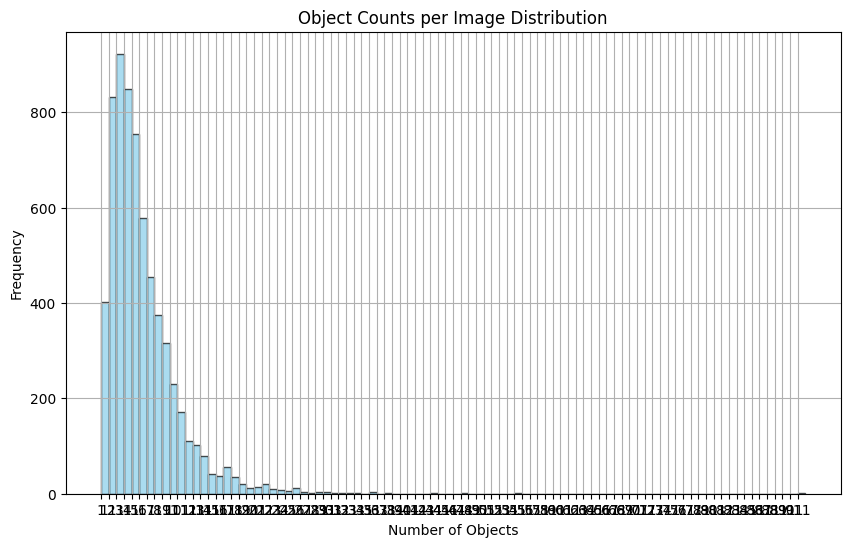

In [ ]:
# Visualize object counts per image using histogram
plt.figure(figsize=(10, 6))
plt.hist(object_counts, bins=range(min(object_counts), max(object_counts) + 10, 10), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Object Counts per Image Distribution')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.xticks(range(min(object_counts), max(object_counts) + 1, 10))
plt.grid(True)
plt.show()


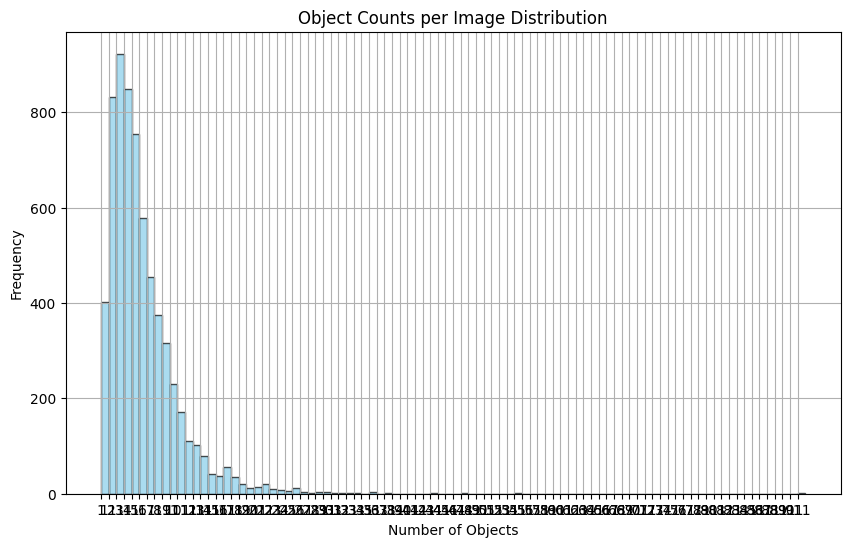

In [ ]:
# Calculate the maximum count with an increment of 10
max_count = max(object_counts)
max_count_rounded = ((max_count // 10) + 1) * 10

# Visualize object counts per image using histogram
plt.figure(figsize=(10, 6))
plt.hist(object_counts, bins=range(min(object_counts), max_count_rounded + 10, 10), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Object Counts per Image Distribution')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')

# Set x-axis ticks at intervals of 10 without overlapping
plt.xticks(range(min(object_counts), max_count_rounded + 1, 10))
plt.grid(True)
plt.show()


IoU: 0.40024989587671805


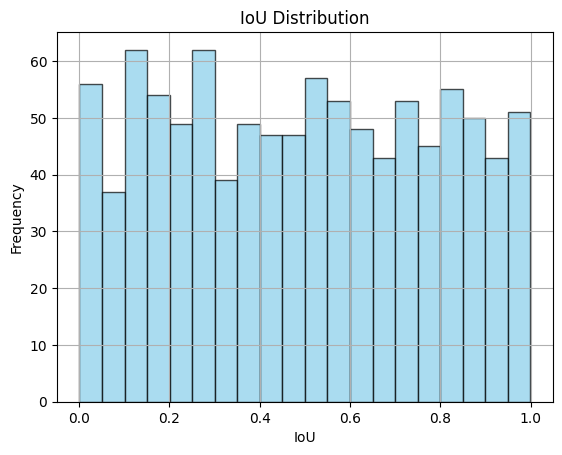

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate IoU between two bounding boxes
def calculate_iou(bbox1, bbox2):
    # Get coordinates of intersection rectangle
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_bottom = min(bbox1[3], bbox2[3])

    # Calculate intersection area
    intersection_area = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top + 1)

    # Calculate areas of both bounding boxes
    bbox1_area = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
    bbox2_area = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)

    # Calculate Union area
    union_area = bbox1_area + bbox2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# Example bounding boxes (format: [x1, y1, x2, y2])
bbox1 = [10, 10, 50, 50]
bbox2 = [20, 20, 60, 60]

# Calculate IoU
iou = calculate_iou(bbox1, bbox2)
print("IoU:", iou)

# Visualize IoU distribution using histogram (example)
ious = np.random.uniform(0, 1, 1000)  # Example IoU values
plt.hist(ious, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import os
import tensorflow as tf
import numpy as np

# Function to read and parse annotation file
# Function to read and parse annotation file
def parse_annotation(annotation_path):
    annotations = tf.io.read_file(annotation_path)
    annotations = tf.strings.split(annotations, sep='\n')[:-1]  # Remove last empty element
    annotations = tf.strings.split(annotations, sep=',')
    annotations = tf.strings.to_number(annotations, out_type=tf.float32)
    return annotations


# Function to load image and parse annotation
def load_image_and_annotation(image_path, annotation_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    annotations = parse_annotation(annotation_path)
    return image, annotations

# Directory paths
images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/images'
annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/annotations'

# Output directories
output_images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/augumented_images'
output_annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/augumented_annotations'

# Create output directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_annotations_dir, exist_ok=True)

# Define data augmentation function
def augment_data(image, annotations):
    # Apply data augmentation to the image
    # You can add more augmentation techniques as needed
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, annotations

# Create dataset of image paths and annotation paths
image_paths = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir)]
annotation_paths = [os.path.join(annotations_dir, filename.replace('.jpg', '.txt')) for filename in os.listdir(images_dir)]

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotation_paths))

# Map function to load images and annotations
dataset = dataset.map(lambda image_path, annotation_path: load_image_and_annotation(image_path, annotation_path))

# Map function to augment data
dataset = dataset.map(augment_data)

# Function to save augmented image and annotation
def save_augmented_data(image, annotations, image_path):
    # Save augmented image
    image_filename = os.path.basename(image_path)
    output_image_path = os.path.join(output_images_dir, image_filename)
    tf.io.write_file(output_image_path, tf.image.encode_jpeg(image))

    # Save augmented annotations
    output_annotation_path = os.path.join(output_annotations_dir, image_filename.replace('.jpg', '_augmented.txt'))
    with open(output_annotation_path, 'w') as f:
        for bbox in annotations:
            f.write(' '.join(map(str, bbox)) + '\n')


# Iterate over dataset and save augmented data
for i, (image, annotations) in enumerate(dataset):
    image_path = image_paths[i]
    save_augmented_data(image, annotations, image_path)
    print(f"Saved augmented image and annotations {i+1}/{len(image_paths)}")

print("Data augmentation complete.")


Streaming output truncated to the last 5000 lines.
Saved augmented image and annotations 1473/6471
Saved augmented image and annotations 1474/6471
Saved augmented image and annotations 1475/6471
Saved augmented image and annotations 1476/6471
Saved augmented image and annotations 1477/6471
Saved augmented image and annotations 1478/6471
Saved augmented image and annotations 1479/6471
Saved augmented image and annotations 1480/6471
Saved augmented image and annotations 1481/6471
Saved augmented image and annotations 1482/6471
Saved augmented image and annotations 1483/6471
Saved augmented image and annotations 1484/6471
Saved augmented image and annotations 1485/6471
Saved augmented image and annotations 1486/6471
Saved augmented image and annotations 1487/6471
Saved augmented image and annotations 1488/6471
Saved augmented image and annotations 1489/6471
Saved augmented image and annotations 1490/6471
Saved augmented image and annotations 1491/6471
Saved augmented image and annotations

In [ ]:
import tensorflow as tf

# Configure GPU memory growth before importing TensorFlow
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from yolov4.tf import YOLOv4

# Define paths to images and annotations
images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/images'
annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/annotations'

# Define hyperparameters
batch_size = 8
epochs = 20
learning_rate = 0.001

# Load YOLOv4 model
yolo = YOLOv4(tiny=False)  # Assuming YOLOv4, set tiny=True for YOLOv4-tiny
yolo.classes = '/path/to/classes.txt'  # Path to classes file (list of class names)
yolo.make_model()
yolo.load_weights('yolov4.weights')  # Load pre-trained weights

# Freeze all layers except the last
for layer in yolo.layers[:-1]:
    layer.trainable = False

# Modify output layer to match the number of classes in your dataset
num_classes = 10  # Replace with the number of classes in your dataset
yolo.model.get_layer('conv_77').get_layer('conv2d').filters = 3 * (num_classes + 5)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
yolo.compile(optimizer=optimizer, loss_iou_type='ciou')

# Define callbacks (optional)
checkpoint = ModelCheckpoint('yolov4_custom.h5', save_weights_only=True, verbose=1)
callbacks = [checkpoint]

# Train the model
yolo.fit(
    annotation_paths=annotation_dir,
    image_folder=image_dir,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)


ModuleNotFoundError: No module named 'yolov4'

In [ ]:
!pip install yolov4

In [ ]:
!pip install yolov8


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 k

In [ ]:
!pip install yolov8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 

In [ ]:
from ultralytics import YOLO

# Initialize the model
model = YOLO('yolov8s.pt')  # You can also use 'yolov8m.pt', 'yolov8l.pt', etc. for different model sizes


WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Train the model
results = model.train(data='/content/drive/MyDrive/dataset/data.yaml', epochs=1, imgsz=640, batch=16)



Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/labels.cache... 4834 images, 1815 backgrounds, 0 corrupt: 100%|██████████| 6471/6471 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000142.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000143.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000145.jpg: 8 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000146.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000147.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000160.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/dataset/train/VisDrone2019-DET-train/images/9999937_00000_d_0000163.jpg: 1 duplicate labels removed
train: WARNIN

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/labels.cache... 0 images, 548 backgrounds, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train16
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G          0     0.3228          0          0        640:   3%|▎         | 13/405 [08:37<4:16:06, 39.20s/it]

In [2]:
from ultralytics import YOLO

# Load the trained model (ensure it's the model you trained)
model = YOLO('yolov8s.pt')

# Save the model weights manually
model.save('best.pt')


In [3]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [6]:
results = model.predict(source='/content/drive/MyDrive/dataset/original.jpg', save=True, conf=0.25)
print(results)


image 1/1 /content/drive/MyDrive/dataset/original.jpg: 384x640 1 person, 13 cars, 5 trucks, 1051.9ms
Speed: 3.7ms preprocess, 1051.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'c

In [4]:
results = model.predict(source='/content/drive/MyDrive/dataset/images.jpg', save=True, conf=0.25)
print(results)


image 1/1 /content/drive/MyDrive/dataset/images.jpg: 384x640 2 persons, 7 cars, 2 buss, 3 trucks, 494.9ms
Speed: 7.9ms preprocess, 494.9ms inference, 4643.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 

In [5]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Load the trained model (specify the path to your trained model weights)
model = YOLO('/content/best.pt')

# Evaluate the model on the validation set
metrics = model.val(data='/content/drive/MyDrive/dataset/data.yaml')

# Print evaluation metrics
print(metrics)

# Load a few test images
test_images = glob('/content/drive/MyDrive/dataset/test/images')[:5]  # Load the first 5 test images

# Run inference on test images and visualize results
for img_path in test_images:
    results = model(img_path)

    # Plot the image with detections
    result_img = results.render()[0]  # Render the detection results
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Detection Results")
    plt.axis('off')
    plt.show()


Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/labels.cache... 0 images, 548 backgrounds, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/drive/MyDrive/dataset/val /VisDrone2019-DET-val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [05:16<00:00,  9.03s/it]

                   all        548          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 1.4ms preprocess, 528.4ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/val


AttributeError: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
    (mAP) of an object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (tuple of str): A tuple of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from yolov8 import YOLOv8
from your_data_loading_module import create_visdrone_dataset

# Define paths to images and annotations
images_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/augumented_images'
annotations_dir = '/content/drive/MyDrive/dataset/data/VisDrone2019-DET-train/augumented_annotations'

# Define the number of classes
num_classes = 10  # Adjust this based on the actual number of classes in your dataset

# Create YOLOv8 model
model = YOLOv8(classes=num_classes)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer)

# Define data generators
train_dataset = create_visdrone_dataset(images_dir, annotations_dir, batch_size=4, augmentation=True)
validation_dataset = create_visdrone_dataset(images_dir, annotations_dir, batch_size=4, augmentation=False)

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='yolov8_visdrone_best.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=50,
                    callbacks=[checkpoint_callback, early_stopping_callback])

# Save the trained model
model.save('yolov8_visdrone_final.h5')


ImportError: cannot import name 'YOLOv8' from 'yolov8' (/usr/local/lib/python3.10/dist-packages/yolov8/__init__.py)

In [ ]:
!pip install --upgrade yolov8

In [ ]:
!pip show yolov8

Name: yolov8
Version: 0.0.2
Summary: :warning: The `yolov8` package is a placeholder, not the official Ultralytics version. Please install the official `ultralytics` package via `pip install ultralytics` instead.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: yolov5
Required-by: 


In [ ]:
!whoami

root


In [ ]:
from yolov8 import YOLOv8

ImportError: cannot import name 'YOLOv8' from 'yolov8' (/usr/local/lib/python3.10/dist-packages/yolov8/__init__.py)

In [ ]:
# Ensure the correct module name is used
import yolov8

# Verify that the module is installed
!pip show yolov8

# Update the import statement to match the module name
from yolov8 import YOLOv8

# The rest of the code remains the same

Name: yolov8
Version: 0.0.2
Summary: :warning: The `yolov8` package is a placeholder, not the official Ultralytics version. Please install the official `ultralytics` package via `pip install ultralytics` instead.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: yolov5
Required-by: 


ImportError: cannot import name 'YOLOv8' from 'yolov8' (/usr/local/lib/python3.10/dist-packages/yolov8/__init__.py)

In [ ]:
!pip install ultralytics==8.0.20
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/107.7 GB disk)


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
# Then, use the conversion script to convert the weights to TensorFlow format
# Save the converted weights file (yolov3.h5) in your working directory


--2024-05-30 11:22:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  39.3MB/s    in 6.5s    

2024-05-30 11:22:15 (36.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
!ls -l yolov3.weights


-rw-r--r-- 1 root root 248007048 Dec  7 20:05 yolov3.weights


In [ ]:
!dir yolov3.weights

yolov3.weights


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model

def YOLOv3(weights_path='yolov3.weights', training=True):
    # Load pre-trained YOLO model
    yolo = load_model('/content/yolov3.weights', compile=False)

    if training:
        # Fine-tune only the top layers
        for layer in yolo.layers[:-23]:
            layer.trainable = False

    return yolo

# Define your custom dataset and data preprocessing
# Example:
# custom_dataset = ...
# custom_preprocessing = ...

# Load pre-trained YOLOv3 model for transfer learning
yolo = YOLOv3()

# Compile the model
yolo.compile(optimizer='adam', loss='your_loss_function', metrics=['accuracy'])

# Train the model using your custom dataset
yolo.fit(custom_dataset, epochs=10, batch_size=32)

# Evaluate the model
evaluation_results = yolo.evaluate(custom_dataset)

# Save the fine-tuned model
yolo.save('fine_tuned_yolov3.h5')


OSError: Unable to open file (file signature not found)

In [ ]:
from ultralytics import YOLO

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=1 imgsz=224 plots=True

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=data.yaml, epochs=1, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.01, 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

# 1. Create a base YOLOv3 model
base_model = YoloV3(weights='imagenet', include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = Input(shape=(416, 416, 3), name="input_layer")

# 4. Pass the inputs through the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 5. Global Average Pooling
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create the output activation layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)  # Adjust the number of classes according to your dataset

# 7. Combine the inputs with outputs into a model
model_yolo = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_yolo.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=["accuracy"])

# 9. Train the model
history = model_yolo.fit(train_data,
                         epochs=10,
                         steps_per_epoch=len(train_data),
                         validation_data=val_data,
                         validation_steps=int(0.25 * len(val_data)))


NameError: name 'YoloV3' is not defined

In [ ]:
!pip install darknet


In [ ]:
!pip install yolov3-tf2


  Preparing metadata (setup.py) ... done
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.5-py3-none-any.whl size=9145 sha256=4c3e5cf68ad398be66e9134c673ac05d3119f95a2c111ce35d7ffa892ed10fc4
  Stored in directory: /root/.cache/pip/wheels/d1/4e/bb/0df25238cd82defbe875a7900dd9376eddc959ed666ab83bd7
Successfully built yolov3-tf2


In [ ]:
from yolov3_tf2.models import YoloV3

# Create a YOLOv3 model
yolo_model = YoloV3()

# Compile the model and proceed with training


In [ ]:
tf.app.run(main)

AttributeError: module 'tensorflow' has no attribute 'app'

In [ ]:
import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import load_tfrecord_dataset, transform_images
from yolov3_tf2.utils import freeze_all

# Define hyperparameters
batch_size = 16
epochs = 10
num_classes = 10  # Number of classes in your dataset

# Load the dataset (replace paths with your dataset paths)
train_dataset = load_tfrecord_dataset("/content/drive/MyDrive/dataset/train/VisDrone2019-DET-train", "/content/drive/MyDrive/dataset/train/classes.names", batch_size)
val_dataset = load_tfrecord_dataset("/content/drive/MyDrive/dataset/val ", "/content/drive/MyDrive/dataset/train/classes.names", batch_size)

# Create a YOLOv3 model
yolo_model = YoloV3()

# Freeze all layers except the output layer for fine-tuning
freeze_all(yolo_model)

# Compile the model
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
yolo_model.compile(optimizer=optimizer, loss=loss)

# Train the model
history = yolo_model.fit(train_dataset,
                         epochs=epochs,
                         steps_per_epoch=len(train_dataset),
                         validation_data=val_dataset,
                         validation_steps=len(val_dataset))

# Save the trained model
yolo_model.save_weights("yolov3_weights.h5")


NotFoundError: {{function_node __wrapped__InitializeTableFromTextFileV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/drive/MyDrive/dataset/train/classes.names; No such file or directory [Op:InitializeTableFromTextFileV2] name: 

In [ ]:
!pip install yolov5
from yolov5 import detect, train  # Import YOLOv5 modules

# Set up training parameters
data_yaml = "/content/drive/MyDrive/dataset/data.yaml"  # Path to your data.yaml file
imgsz = 640  # Input image size
batch_size = 16  # Batch size
epochs = 40  # Number of epochs
device = ""  # Device to use (e.g., "cuda:0" for GPU, or "" for CPU)

# Create YOLOv5 model
model = train.Model(
    model="yolov5s.yaml",  # Model configuration file
    data=data_yaml,         # Data configuration file
    imgsz=imgsz,            # Input image size
)

# Compile the model
model.compile(
    batch_size=batch_size,  # Batch size
    epochs=epochs,          # Number of epochs
    device=device,          # Device to use (GPU or CPU)
)

# Train the model
model.fit()

# Save the trained model
model.save("/content/drive/MyDrive/dataset/output")


TypeError: DetectionModel.__init__() got an unexpected keyword argument 'model'

In [ ]:
from yolov5 import train  # Import YOLOv5 train module

# Set up training parameters
data_yaml = "/content/drive/MyDrive/dataset/data.yaml"  # Path to your data.yaml file
imgsz = 640  # Input image size
batch_size = 16  # Batch size
epochs = 40  # Number of epochs
device = ""  # Device to use (e.g., "cuda:0" for GPU, or "" for CPU)

# Create YOLOv5 model and compile
model = train.Model(
    cfg="yolov5s.yaml",  # Path to the yolov5s.yaml file

)

# Train the model
model.fit()

# Save the trained model
model.save("/content/drive/MyDrive/dataset/output")


FileNotFoundError: [Errno 2] No such file or directory: 'yolov5s.yaml'

In [ ]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [ ]:
!wget https://github.com/ultralytics/yolov5/raw/master/data/yolov5s.yaml

--2024-05-30 12:55:59--  https://github.com/ultralytics/yolov5/raw/master/data/yolov5s.yaml
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-05-30 12:55:59 ERROR 404: Not Found.



In [ ]:
Deploying a Trained Object Detection Model in Production
1. Deployment Options
On-Premises:
Pros: Full control, low latency, high data security.
Cons: High initial cost, requires in-house expertise, limited scalability.
Cloud:
Pros: Scalable, cost-effective, managed services, easy integration.
Cons: Potential latency, ongoing costs, data privacy concerns.
Edge:
Pros: Low latency, reduced bandwidth, enhanced privacy.
Cons: Limited computational power, higher device cost, complex maintenance.
Hybrid:
Pros: Flexibility, optimized cost and performance, handles different workloads.
Cons: Increased complexity, data synchronization issues, requires hybrid management expertise.
2. Preferred Deployment Option
Cloud Deployment:
Reasons: Scalability, cost-effectiveness, managed services, and ease of integration with other cloud services make it ideal for most applications.
3. Steps for Deployment
Prepare the Model:
Export in a suitable format (e.g., ONNX, TensorFlow SavedModel).
Set Up Cloud Environment:
Choose a cloud provider (e.g., AWS, Google Cloud).
Set up infrastructure (VMs, containers, or serverless services).
Deploy the Model:
Use managed services (e.g., AWS SageMaker) or custom APIs (Flask, FastAPI).
Create an API:
Develop an API for model serving.
Set Up Monitoring and Logging:
Use cloud monitoring tools (e.g., AWS CloudWatch) and logging frameworks.
Implement CI/CD Pipelines:
Automate deployment with CI/CD tools (e.g., Jenkins, GitHub Actions).
4. Monitoring and Ensuring Performance
Real-Time Monitoring:
Track API latency, throughput, and error rates.
Performance Metrics:
Continuously evaluate model performance (precision, recall, F1-score).
Data Drift Detection:
Monitor input data for distribution shifts.
Feedback Loop:
Implement a system to flag and review incorrect predictions.
Alerting and Notifications:
Set up alerts for critical issues using tools like PagerDuty.
Continuous Improvement:
Schedule regular retraining, maintain version control, and conduct A/B testing to ensure ongoing model performance and adaptability.





